In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
dataset=np.load("data/global_domain_float16_all.npy")[:]

In [9]:
dataset.shape

(1000, 3, 128, 64, 128)

In [10]:
def flip_dataset(data):
    axes_combinations = [
        (),  # No flip (original)
        (2,),  # x-axis (depth)
        (3,),  # y-axis (height)
        (4,),  # z-axis (width)
        (2, 3),  # xy-plane
        (2, 4),  # xz-plane
        (3, 4),  # yz-plane
        (2, 3, 4)  # xyz
    ]
    flipped_datasets = [np.flip(data, axis=axes) for axes in axes_combinations]
    return flipped_datasets

# Create two datasets with a stride of 2
stride_1 = dataset[::2]  # t0, t2, t4, ...
stride_2 = dataset[1::2]  # t1, t3, t5, ...

# Combine the original and stride datasets
all_datasets = [dataset, stride_1, stride_2]

# Apply flipping to all datasets
augmented_datasets = []
for data in all_datasets:
    augmented_datasets.extend(flip_dataset(data))


In [6]:
for i, data in enumerate(augmented_datasets):
    print(data.dtype)

float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16
float16


In [11]:
import os
os.makedirs("data/augmented", exist_ok=True)
for i, data in enumerate(augmented_datasets):
    np.save(f"data/augmented/augmented_dataset_{i}", data)

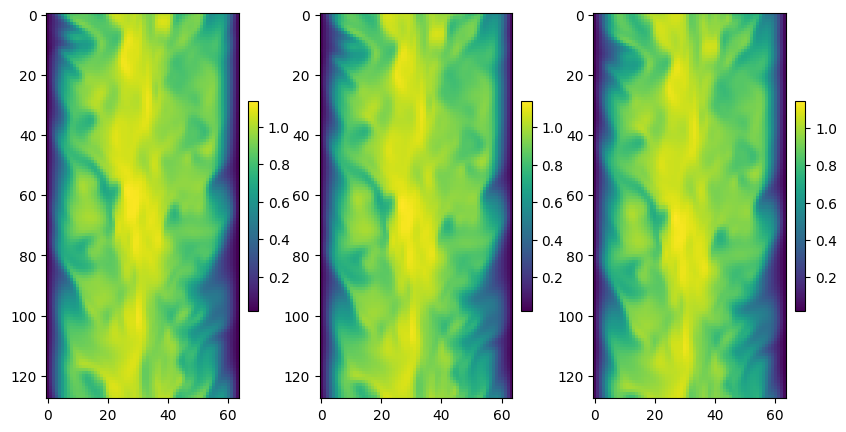

In [28]:
def plot_input_target_pred(dataset: np.ndarray, start=0, stride=20):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    im0 = axes[0].imshow(dataset[start, 0, :, :, 50], cmap="viridis")
    im1 = axes[1].imshow(dataset[start + stride, 0, :, :, 50], cmap="viridis")
    im2 = axes[2].imshow(dataset[start + 2 * stride, 0, :, :, 50], cmap="viridis")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    plt.show()


plot_input_target_pred(dataset)

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)  # shape: [max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(
            1
        )  # [max_len, 1]
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-torch.log(torch.tensor(10000.0)) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices
        pe = pe.unsqueeze(1)  # [max_len, 1, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x shape: [sequence_length, batch_size, d_model]
        x = x + self.pe[: x.size(0)]
        return x


class FlowPredictionModel(nn.Module):
    def __init__(self, in_channels=3, feature_dim=512, num_layers=4, num_heads=8):
        super(FlowPredictionModel, self).__init__()
        # 3D Conv layers for spatial feature extraction
        self.conv3d = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(32),
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(64),
            nn.Conv3d(64, feature_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(feature_dim),
            nn.AdaptiveAvgPool3d(1),
        )
        # Positional Encoding for Transformer
        self.pos_encoder = PositionalEncoding(feature_dim)
        # Transformer Encoder for temporal dependencies
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_dim, nhead=num_heads, batch_first=False
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )
        # Decoder to reconstruct the next timestep's 3D field
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(feature_dim, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(128),
            nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(64),
            nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(32),
            nn.ConvTranspose3d(
                32,
                in_channels,
                kernel_size=(4, 4, 2),
                stride=(2, 2, 1),
                padding=(1, 1, 0),
            ),
        )
        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize weights for Conv and ConvTranspose layers
        for m in self.modules():
            if isinstance(m, (nn.Conv3d, nn.ConvTranspose3d)):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

    def _num_parameters(self):
        count = 0
        for name, param in self.named_parameters():
            # print(name, param.numel())
            count += param.numel()
        return count

    def forward(self, x):
        # x shape: [batch, time, channels, depth, height, width]
        batch_size, time_steps, channels, depth, height, width = x.shape
        features = []
        for t in range(time_steps):
            xt = x[:, t]  # shape: [batch, channels, depth, height, width]
            ft = self.conv3d(xt)  # shape: [batch, feature_dim, 1, 1, 1]
            ft = ft.view(batch_size, -1)  # shape: [batch, feature_dim]
            features.append(ft)
        features = torch.stack(
            features, dim=1
        )  # shape: [batch, time_steps, feature_dim]
        features = features.permute(1, 0, 2)  # shape: [time_steps, batch, feature_dim]
        # Apply positional encoding
        features = self.pos_encoder(features)
        # Transformer expects input of shape [sequence_length, batch_size, feature_dim]
        transformer_output = self.transformer_encoder(features)
        # Use the last output to predict the next timestep
        last_output = transformer_output[-1]  # shape: [batch, feature_dim]
        # Reshape last_output to [batch, feature_dim, 1, 1, 1]
        last_output = last_output.view(batch_size, -1, 1, 1, 1)
        # Decode to reconstruct the next timestep's 3D field
        out = self.decoder(
            last_output
        )  # shape: [batch, channels, depth, height, width]
        return out


# Example usage:
if __name__ == "__main__":
    # Input shape: [batch_size, time_steps, channels, depth, height, width]
    batch_size = 2
    time_steps = 10
    channels = 3
    depth = 16
    height = 16
    width = 8
    input_data = torch.randn(batch_size, time_steps, channels, depth, height, width)
    model = FlowPredictionModel(in_channels=channels)
    output = model(input_data)
    print("Output shape:", output.shape)
    # Expected output shape: [batch_size, channels, depth, height, width]

Output shape: torch.Size([2, 3, 16, 16, 9])


In [24]:
model._num_parameters()

18407395